In [110]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from torch.distributions.multivariate_normal import MultivariateNormal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [111]:
def Radon_Nikodym_derivative(dist_pi, dist_mu, a_n):
    """
    Compute log Radon-Nikodym derivative log p^θ = log (dπ^θ/dµ) = log dπ^θ - log dµ

    Input:
        dist_pi: the distribution of π^θ
        dist_mu: the distribution of µ
        a_n: control a
    Output:
        RN: log Radon-Nikodym derivative for the given a_n
    """
    RN = dist_pi.log_prob(a_n) - dist_mu.log_prob(a_n)

    return RN

In [112]:
class SoftLQREnvironment:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        Initialize soft LQR environment

        Parameters:
            H, M, C, D, R: Matrix of linear quadratic regulator
            sigma: Noise term
            T: Terminal time
            N: The number of time steps
            dt: time steps
            tau: strength of entropic regularization
            gamma: strength of variance of prior normal density 
            time_grid: Time grid
            D_eff: Correction term D
            dist_mu: the distribution of µ, µ = N(0, γ^2 Imxm)
            S_values: The solution of Ricatti ODE
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.dt = T/N
        self.time_grid = torch.linspace(0, T, N+1)
        self.tau = tau
        self.gamma = gamma
        self.D_eff = self.D + (self.tau / (2 * (self.gamma ** 2))) * torch.eye(2)
        self.dist_mu = MultivariateNormal(torch.zeros(2), gamma**2*torch.eye(2))
        self.S_values = self.solve_ricatti_ode()
        self.integral_cache = self.precompute_integrals()
        self.C_const = self.precompute_C()
    
    def ricatti_ode(self, t, S_flat):
        """
        Obtain the expression of Riccati ODE: 
            S'(t) = S(t) M D^{-1} M^{T} S(t) - H^{T} S(t) - S(t) H - C , S(T) = R
        
        Input:
            t: current time
            S_flat: S value at time t
        output:
            S_dot.flatten(): Solve the derivative of S and convert to one dimension
        """
        # Reshape S for 2x2 matrix
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2,2) 
        # Compute the derivative of S(t)
        S_dot = S.T @ self.M @ torch.linalg.inv(self.D_eff) @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        
        return S_dot.flatten()
    
    def solve_ricatti_ode(self):
        """
        Use solve_ivp to solve Ricatti ODE 

        Output:
            Return a dictionary with corresponding time and S values one by one
        """
        # Terminal S
        S_T = self.R.flatten() 
        # Generate reverse index
        index = torch.arange(self.time_grid.size(0) - 1, -1, -1)
        # Reverse time grid
        time_grid_re = torch.index_select(self.time_grid, 0, index)

        # Solve Ricatti ODE
        sol = solve_ivp(self.ricatti_ode, [self.T, 0], S_T, t_eval = time_grid_re, atol = 1e-10, rtol = 1e-10)  
        # Convert back to matrix format
        S_matrix = sol.y.T[::-1].reshape(-1, 2, 2) 

        return dict(zip(tuple(self.time_grid.tolist()), S_matrix))

    def get_nearest_S(self, t):
        """
        Find the value of S that is closest to t

        Input:
            t: time
        Output:
            self.S_values[nearest_t.item()]: S(t) that is closest to t
        """
        # Find the nearest t
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        
        return self.S_values[nearest_t.item()]
    
    def value_function(self, t, x):
        """
        Compute the value funtion:
            v(t, x) = x^T S(t) x + ∫[t,T] tr(σσ^T S(r)) dr + (T-t)C_{D,tau, gamma}
        
        Input: 
            t: time
            x: initial x
        Output:
            value: the control problem value v(t, x) for the given t, x
        """
        # First term：x^T S(t) x
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype = torch.float32)
        first_term = x.T @ S_t @ x
        
        # Second term: ∫[t,T] tr(σσ^T S(r)) dr
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        second_term = self.integral_cache[nearest_t.item()]

        # Third term：(T-t)C_{D,tau, gamma}
        entropic = (self.T - t) * self.C_const

        value = first_term + second_term + entropic

        return value
    
    def optimal_control(self, t, x):
        """
        Compute the optimal control distribution:
            pi(·|t, x) = N(-(D+tau/(2*gamma^2)I)^(-1) M^T S(t) x, tau(D+tau/(2*gamma^2)I))
        
        Input: 
            t: time
            x: initial x
        Output:
            control_dist: the optimal control distribution pi(·|t, x) for the given t, x
        """
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        # mean
        mean_control = -torch.linalg.inv(self.D_eff) @ self.M.T @ S_t @ x
        # covarian
        cov_control = self.tau * self.D_eff
        # distribution
        control_dist = MultivariateNormal(mean_control, cov_control)
        return control_dist

    def precompute_integrals(self):
        """
        Precompute ∫ tr(σσ^T S(r)) dr over all time points
        """
        int_table = []
        for t in self.time_grid:
            def integrand(r):
                S_r = self.get_nearest_S(r)
                return torch.trace(self.sigma @ self.sigma.T @ S_r).item()
            # Using numerical integration to calculate the integral term
            val, _ = quad(integrand, t.item(), self.T)
            int_table.append(val)

        return dict(zip(self.time_grid.tolist(), int_table))
    
    def precompute_C(self):
        """
        Precompute C_{D,tau, gamma} = -tau ln(tau^{m/2}/gamma^{m} * det(∑)^{1/2}), ∑-1 = D+tau/(2*gamma^2)I
        """
        inv_matrix = torch.linalg.inv(self.D_eff)
        det_matrix = torch.det(inv_matrix)
        C = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))

        return C

    def reset(self):
        """
        Initialize x0, initial state distribution ρ = U([-2, 2] x [-2, 2])
        """
        x0 = torch.tensor([torch.empty(1).uniform_(-2, 2), torch.empty(1).uniform_(-2, 2)], dtype = torch.float32)
        return x0
    
    def simulate_trajectory(self, x0, dW):
        """
        Use Euler scheme to simulate soft LQR trajectory
        Explicit Euler:
            X_tn+1 = X_tn + dt [H X_tn - M D^{-1} M^{T} S(tn) X_tn )] + σ(W_tn+1 - W_tn ),

        Input:
            x0: Initial x
            dW: Brownian motion
        Output:
            np.array(x_traj): the LQR trajectory of x for the given x0, dW
            cost_opt_cum: the cumulative cost for the given x0, dW
        """
        x_traj = [x0.numpy()]
        cost_opt = []
        x_tn = x0
        
        for n in range(self.N):
            tn = n * self.dt
            S_tn = self.get_nearest_S(tn)
            S_tn = torch.tensor(S_tn, dtype = torch.float32)

            # mean
            mean_control = -torch.linalg.inv(self.D_eff) @ self.M.T @ S_tn @ x_tn     
            
            # covarian
            cov_control = self.tau * self.D_eff

            # distribution
            control_dist = MultivariateNormal(mean_control, cov_control)
            a_n = control_dist.sample()

            # cost
            cost_n = x_tn.T @ self.C @ x_tn + a_n.T @ self.D @ a_n
            # Compute log Radon-Nikodym derivative log p^θ
            log_prob = Radon_Nikodym_derivative(control_dist, self.dist_mu, a_n)
            # Compute running cost: f_tn + τ * ln p^θ
            running_cost_n = cost_n + self.tau * log_prob
            cost_opt.append(running_cost_n.unsqueeze(0))

            # drift = Hx + Ma
            drift = self.H @ x_tn + self.M @ a_n

            # noise = sigma dW
            noise = self.sigma @ dW[n]

            # explicit Euler scheme
            x_next = x_tn + drift * self.dt + noise
            x_tn = x_next
            x_traj.append(x_tn.numpy())
        
        # Terminal cost
        g_T = x_tn.T @ self.R @ x_tn
        cost_opt.append(g_T.unsqueeze(0))

        cost_opt = torch.stack(cost_opt)
        cost_opt_cum = torch.cumsum(cost_opt, dim = 0)

        return np.array(x_traj), cost_opt_cum

In [113]:
class PolicyNN(nn.Module):
    def __init__(self, hidden_size = 512):
        """
        A neural network policy that outputs parameters of a multivariate normal distribution
        This network maps 1D input (e.g. time index) into:
            phi: a 2x2 matrix used in mean
            sigma_L: a lower-triangular matrix used to build the covariance matrix Σ = L @ L.T

        Parameters:
            hidden_layer1 (nn.Linear): First fully connected hidden layer.
            hidden_layer2 (nn.Linear): Second fully connected hidden layer.
            dim (int): Dimensionality of the output matrix (e.g., action dimension).
            phi (nn.Linear): Output layer to produce flattened 2x2 matrix.
            sigma_L (nn.Linear): Output layer to produce flattened lower-triangular matrix (3 values for 2x2).
            tri_indices (torch.Tensor): Indices to map flat elements to lower-triangular matrix.
        """
        super(PolicyNN, self).__init__()

        self.hidden_layer1 = nn.Linear(1, hidden_size) 
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.dim = 2

        # Output for phi 
        self.phi = nn.Linear(hidden_size, 2 * 2)
        # Output for L matrix for Sigma 
        self.sigma_L = nn.Linear(hidden_size, 2 * (2 + 1) // 2)

        # Precompute 
        self.tri_indices = torch.tril_indices(self.dim, self.dim)
    
    def forward(self, t, x):
        """
        Forward pass to get the action distribution.
        Returns a MultivariateNormal distribution.

        Input:
            t: current time
            x: current x
        Output:
            MultivariateNormal(mean, cov_matirx): a MultivariateNormal distribution with mean and covariance
        """

        # Forward pass 
        t = t.view(-1, 1)  # Ensure t is a column vector 
        hidden = torch.relu(self.hidden_layer1(t)) 
        hidden = torch.sigmoid(self.hidden_layer2(hidden))

        # Compute phi 
        phi_flat = self.phi(hidden) 
        phi = phi_flat.view(-1, self.dim, self.dim)

        # Compute Sigma 
        L_flat = self.sigma_L(hidden) 
        # Create a lower triangular matrix L where L_flat fills the lower triangle 
        L = torch.zeros(self.dim, self.dim) 
        L[self.tri_indices[0], self.tri_indices[1]] = L_flat 
        
        # Compute Sigma = LL^T to ensure positive semi-definiteness 
        Sigma = L @ L.T + 1e-4 * torch.eye(2).unsqueeze(0)

        # mean
        mean = phi @ x
        # variance
        cov_matirx = Sigma

        return MultivariateNormal(mean, cov_matirx)

In [ ]:
def OfflinePolicyGradient(env, policyNN, n_episodes, lr):
    """
    dostring
    """
    actor_optim = optim.Adam(policyNN.parameters(), lr = lr)

    cost_history = []
    # Start to train
    for ep in range(n_episodes):
        # Sample x0
        x0 = env.reset()
        dW = torch.randn(env.N, 2) * np.sqrt(env.dt)
        x_tn = x0.clone()

        t_list = []
        x_list = []
        v_list = []
        cost_list = []
        logp_list = []
        
        # Simulate a trajectory
        for n in range(env.N):
            # Forward
            tn = n * env.dt
            # Compute value
            v_n = env.value_function(tn, x_tn)
            
            tn = torch.tensor([tn], dtype=torch.float32)
            # Use policy neural network to output a distribution
            dist = policyNN.forward(tn, x_tn)   
            # Sample action a_n from distribution 
            a_n = dist.rsample().squeeze()

            # Compute log Radon-Nikodym derivative log p^θ
            log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)

            # cost: f_tn
            f_n = x_tn.T @ env.C @ x_tn + a_n.T @ env.D @ a_n
            # running cost
            cost_n = f_n + env.tau * log_prob

            # Use explicit euler to get new state x_tn+1
            drift = env.H @ x_tn + env.M @ a_n
            noise = env.sigma @ dW[n]
            x_next = x_tn + drift * env.dt + noise

            # Store data
            t_list.append(tn)
            x_list.append(x_tn)
            v_list.append(v_n)
            cost_list.append(cost_n)
            logp_list.append(log_prob)

            # Update
            x_tn = x_next

        x_T = x_tn
        # Terminal cost
        g_T = x_T.T @ env.R @ x_T
        # Terminal value
        v_T = env.value_function(env.T, x_T)
        v_list.append(v_T)

        # Convert list to torch.tensor
        v = torch.stack(v_list)
        logprob = torch.stack(logp_list)
        cost = torch.stack(cost_list)
        cost_history.append(sum(cost))

        # Compute delta_v
        delta_v = torch.diff(v)

        # Compute G_hat
        inside_list = []
        for n in range(env.N):
            inside_n = delta_v[n] + cost[n] * env.dt
            inside_list.append(inside_n)
        inside = torch.stack(inside_list)

        G_hat = -torch.sum(logprob * inside.detach())
        actor_optim.zero_grad()
        G_hat.backward()
        actor_optim.step()

        # print(f"Epoch {ep + 1}: ActorGrad = {G_hat.item():.6f}")
        if ep % 100 == 0:
            print(f"Epoch {ep}: ActorGrad = {G_hat.item():.6f}")

    return cost_history


In [149]:
# test
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.eye(2)
# D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 100

tau = 0.5
gamma = 1
n_episodes = 1
lr = 1e-4

# Initialize SoftLQR environment
env = SoftLQREnvironment(H, M, C, D, R, sigma, T, N, tau, gamma)

actor = PolicyNN(hidden_size = 256)

cost_history = OfflinePolicyGradient(env, actor, n_episodes, lr)

/var/folders/v2/6ng3y8s56xj9gxj_r0zfs4jm0000gn/T/ipykernel_49213/963047489.py:148: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, _ = quad(integrand, t.item(), self.T)


Epoch 1: ActorGrad = -98.161865


In [126]:
print(cost_history[0].tolist())

[4152.72021484375, 4200.31787109375, 4218.40966796875, 4152.75146484375, 4154.6357421875, 4141.5185546875, 4179.15380859375, 4161.8623046875, 4189.3173828125, 4273.89794921875, 4167.29931640625, 4191.71923828125, 4174.6044921875, 4173.77978515625, 4277.97509765625, 4204.4306640625, 4249.31689453125, 4269.62939453125, 4222.8095703125, 4198.3984375, 4381.2685546875, 4273.33251953125, 4207.93115234375, 4227.57568359375, 4279.72216796875, 4228.3359375, 4233.5078125, 4288.3427734375, 4355.48779296875, 4267.45068359375, 4246.4609375, 4247.794921875, 4272.8388671875, 4272.38818359375, 4402.64990234375, 4280.25830078125, 4364.86376953125, 4441.1142578125, 4404.375, 4419.25830078125, 4370.11376953125, 4471.783203125, 4331.5615234375, 4346.31640625, 4294.0068359375, 4499.99560546875, 4293.41015625, 4326.990234375, 4279.6826171875, 4313.921875, 4459.23486328125, 4286.43017578125, 4316.88427734375, 4412.373046875, 4302.89892578125, 4394.20947265625, 4299.04833984375, 4500.58349609375, 4443.3803710

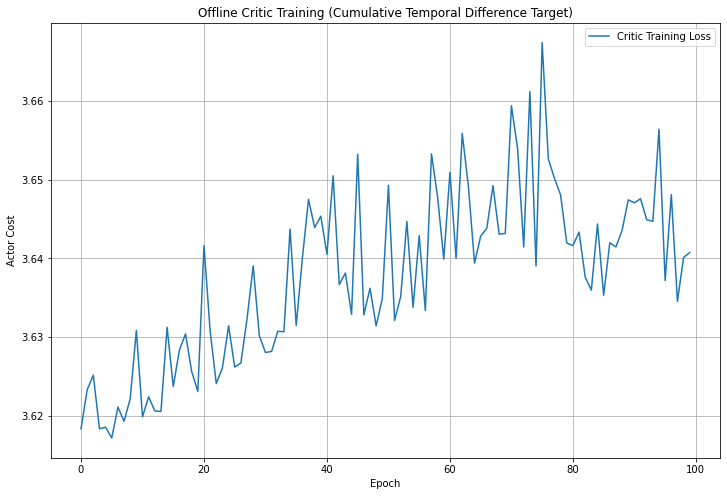

In [127]:
# cost_his = torch.tensor(cost_history, dtype = torch.float32)
cost_his = cost_history[0].tolist()
plt.figure(figsize = (12,8))
plt.plot(np.log10(cost_his), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Actor Cost')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()

In [128]:
data = np.array(cost_his)  # 原始数据转换为 NumPy 数组
chunk_size = 50

# 保证长度是 chunk_size 的整数倍（可以裁剪或补0）
num_chunks = len(data) // chunk_size
print(num_chunks)
data_trimmed = data[:num_chunks * chunk_size]

# reshape 为 (num_chunks, chunk_size)，按行求均值
averages = data_trimmed.reshape(-1, chunk_size).mean(axis=1)
print(averages)

2
[4271.54575195 4413.94016602]


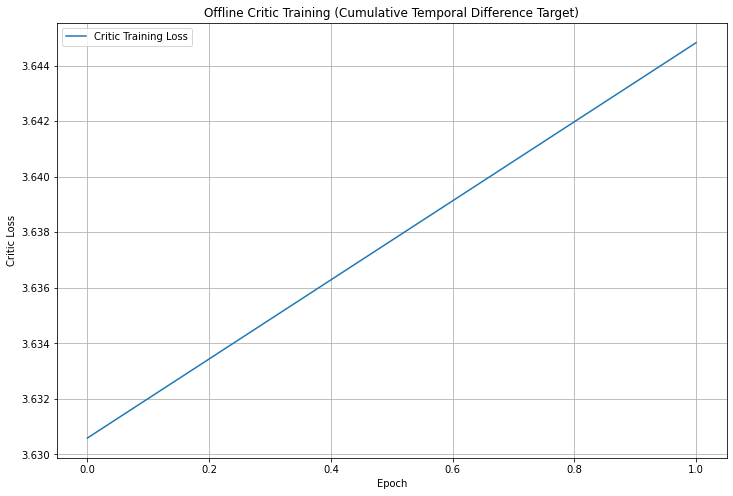

In [129]:
plt.figure(figsize = (12,8))
plt.plot(np.log10(averages), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()

In [130]:
def plot_criticloss(criticloss):
    """
    Plot the critic loss curve (in log10 scale) over training iterations or epochs.
    If average == True, the function averages the loss values over fixed-size chunks 
    (default: 500 steps per epoch) to reduce noise and visualize the overall trend more clearly.

    Input:
        criticloss: A list of critic loss values collected during training.
        average: Whether to average the loss values over epochs. 
                 When set to True, the loss values are grouped into chunks of 500 steps, 
                 and the mean of each chunk is plotted.
    """
    critic_loss = torch.tensor(criticloss, dtype = torch.float32)

    plt.figure(figsize = (12,5))
    plt.plot(np.log10(critic_loss), label='Critic log Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Critic Loss(log)')
    plt.title('Critic log of loss over Epoch')
    plt.grid()
    plt.legend()
    plt.show()
        
def training_test(env, policyNN, x0, dW):
    """
    Simulate one trajectory using the learned policy,
    and computes the cumulative cost over time.

    Input:
        env: A soft LQR environment
        policyNN: Policy neural network that outputs a distribution given t, x.
        x0: Initial state
        dW: Brownian motion
    Output:
        x_traj_learn: The simulated state trajectory under the learned policy.
        cost_learn_cum: The cumulative cost at each time step, including the terminal cost.
    """
    x_tn = x0.clone()
    x_traj_learn = []    
    cost_learn = []   
    for n in range(env.N):
        tn = n * env.dt

        S_tn = env.get_nearest_S(tn)
        S_tn = torch.tensor(S_tn, dtype = torch.float32)
        
        tn = torch.tensor([tn], dtype=torch.float32)
        # Use policy neural network to output a distribution
        dist = policyNN.forward(tn, x_tn)    
        # Sample action a_n from distribution
        a_n = dist.sample().squeeze()
        
        # cost f_tn
        cost_n = (x_tn.T @ env.C @ x_tn) + (a_n.T @ env.D @ a_n)
        # Compute log Radon-Nikodym derivative log p^θ
        log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)
        # Compute running cost: f_tn + τ * ln p^θ
        running_cost_n = cost_n + env.tau * log_prob
        cost_learn.append(running_cost_n)

        # Use explicit euler to get new state x_tn+1
        drift = env.H @ x_tn + env.M @ a_n
        noise = env.sigma @ dW[n]
        x_next = x_tn + drift * env.dt + noise
        x_traj_learn.append(x_tn.numpy())
        x_tn = x_next
    # Terminal cost
    g_T = x_tn.T @ env.R @ x_tn
    cost_learn.append(g_T.unsqueeze(0))

    x_traj_learn = np.array(x_traj_learn)
    cost_learn = torch.stack(cost_learn)
    cost_learn_cum = torch.cumsum(cost_learn, dim = 0)

    return x_traj_learn, cost_learn_cum

def plot_trajectory_cost(initial_states, env, Actor, dW):
    """
    Plot state trajectories and cumulative costs over time for multiple initial states,
    comparing the learned offline Actor-Critic policy with the theoretical optimal solution.

    Input:
        initial_states: A list of initial state
        env: A soft LQR environment
        Actor: Policy neural network that outputs a distribution given t, x.
        dW: Brownian motion
    """
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 12))

    for i, x0 in enumerate(initial_states):
        x_traj_learn, cost_learn_cum = training_test(env, Actor, x0, dW)
        x_traj_optim, cost_optim_cum = env.simulate_trajectory(x0, dW)

        axes[i, 0].plot(x_traj_learn[:,0], x_traj_learn[:,1], label = "Learned Offline AC")
        axes[i, 0].plot(x_traj_optim[:,0], x_traj_optim[:,1], label = "Theoretical Optimal")
        axes[i, 0].scatter(x0[0].item(),x0[1].item(), color = 'green', s = 40, label = "Initial State")
        axes[i, 0].set_xlabel("x1")
        axes[i, 0].set_ylabel("x2")
        axes[i, 0].set_title(f"Trajectory from Initial State [{x0[0].item()},{x0[1].item()}]")
        axes[i, 0].legend()
        axes[i, 0].grid()

        axes[i, 1].plot(env.time_grid, cost_learn_cum.detach().numpy(), label = "Learned Offline AC")
        axes[i, 1].plot(env.time_grid, cost_optim_cum, label = "Theoretical Optimal")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Cost")
        axes[i, 1].set_title(f"Cost Over Time from Initial State [{x0[0].item()},{x0[1].item()}]")
        axes[i, 1].legend()
        axes[i, 1].grid()
    
    plt.tight_layout()
    plt.show()


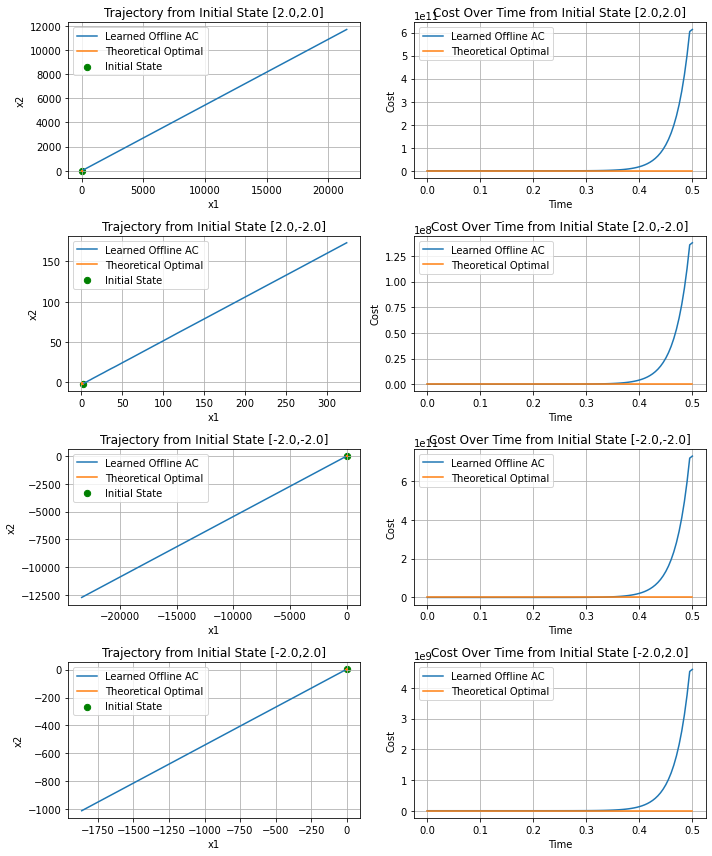

In [131]:
# Test training results
# four initial states
initial_states = torch.tensor([[2.0, 2.0], [2.0, -2.0], [-2.0, -2.0], [-2.0, 2.0]])
# torch.manual_seed(1231)
dW = torch.randn(N, 2) * np.sqrt(env.dt)

# Plot state trajectories and cumulative costs over time for multiple initial states
plot_trajectory_cost(initial_states, env, actor, dW)